In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Strutture di base
class Ray:
    def __init__(self, origin, direction):
        self.origin = origin  # Origine del raggio
        self.direction = direction  # Direzione del raggio (vettore normalizzato)

class Color:
    def __init__(self, r, g, b):
        self.r = r
        self.g = g
        self.b = b

    def __add__(self, other):
        return Color(self.r + other.r, self.g + other.g, self.b + other.b)

    def __mul__(self, scalar):
        return Color(self.r * scalar, self.g * scalar, self.b * scalar)

    def clamp(self):
        self.r = min(1.0, max(0.0, self.r))
        self.g = min(1.0, max(0.0, self.g))
        self.b = min(1.0, max(0.0, self.b))
        return self

# Parametri globali
background_color = Color(0.1, 0.1, 0.1)  # Colore di sfondo
ambient_light = Color(0.1, 0.1, 0.1)  # Luce ambientale
max_depth = 5  # Profondità massima della ricorsione

# Calcolo del colore del pixel
def ray_tracing(framebuffer, camera_position, scene_objects, lights):
    height, width = framebuffer.shape[:2]
    for x in range(width):
        for y in range(height):
            ray = calculate_ray(x, y, width, height, camera_position)
            color = recursive_ray_tracing(ray, scene_objects, lights, 1)
            framebuffer[y, x] = color.clamp()

def recursive_ray_tracing(ray, scene_objects, lights, depth):
    if depth > max_depth:
        return background_color

    # Trova l'intersezione più vicina
    nearest_object, nearest_distance = None, float('inf')
    for obj in scene_objects:
        distance = obj.intersect(ray)
        if distance and distance < nearest_distance:
            nearest_distance, nearest_object = distance, obj

    # Se nessuna intersezione è trovata, ritorna il colore di sfondo
    if not nearest_object:
        return background_color

    # Calcolo del colore nel punto di intersezione
    intersection_point = ray.origin + ray.direction * nearest_distance
    normal = nearest_object.get_normal(intersection_point)
    view_direction = -ray.direction

    # Luce ambientale
    color = ambient_light

    # Calcolo luce diffusa e speculare
    for light in lights:
        light_dir = (light.position - intersection_point).normalized()
        
        # Calcolare l'ombra
        shadow_ray = Ray(intersection_point + normal * 1e-4, light_dir)  # Raggio verso la luce
        if is_in_shadow(shadow_ray, scene_objects):
            continue  # Se in ombra, salta il calcolo della luce per questa sorgente

        # Diffusa
        diffuse_intensity = max(0, normal.dot(light_dir))
        diffuse_color = nearest_object.material.diffuse * diffuse_intensity

        # Speculare
        reflection = (2 * normal.dot(light_dir) * normal - light_dir).normalized()
        specular_intensity = max(0, view_direction.dot(reflection)) ** nearest_object.material.shininess
        specular_color = nearest_object.material.specular * specular_intensity

        color += light.color * (diffuse_color + specular_color)

    # Riflessi
    if nearest_object.material.reflective > 0:
        reflected_direction = reflect(ray.direction, normal)
        reflected_ray = Ray(intersection_point + normal * 1e-4, reflected_direction)
        reflected_color = recursive_ray_tracing(reflected_ray, scene_objects, lights, depth + 1)
        color += reflected_color * nearest_object.material.reflective

    # Rifrazione (trasparenza)
    if nearest_object.material.transparency > 0:
        refracted_direction = refract(ray.direction, normal, nearest_object.material.refractive_index)
        refracted_ray = Ray(intersection_point - normal * 1e-4, refracted_direction)
        refracted_color = recursive_ray_tracing(refracted_ray, scene_objects, lights, depth + 1)
        color += refracted_color * nearest_object.material.transparency

    return color

# Funzioni di utilità
def calculate_ray(x, y, width, height, camera_position):
    # Calcola la direzione del raggio per un pixel specifico
    aspect_ratio = width / height
    screen_x = (x / width) * 2 - 1
    screen_y = 1 - (y / height) * 2
    direction = np.array([screen_x * aspect_ratio, screen_y, -1]).normalized()
    return Ray(camera_position, direction)

def is_in_shadow(ray, scene_objects):
    for obj in scene_objects:
        if obj.intersect(ray):
            return True
    return False

def reflect(direction, normal):
    return direction - 2 * direction.dot(normal) * normal

def refract(direction, normal, refractive_index):
    cosi = -max(-1, min(1, direction.dot(normal)))
    etai, etat = (1, refractive_index) if cosi < 0 else (refractive_index, 1)
    normal = -normal if cosi < 0 else normal
    eta = etai / etat
    k = 1 - eta ** 2 * (1 - cosi ** 2)
    return eta * direction + (eta * cosi - np.sqrt(k)) * normal if k >= 0 else None

# Classe oggetti scena (esempio)
class Sphere:
    def __init__(self, center, radius, material):
        self.center = center
        self.radius = radius
        self.material = material

    def intersect(self, ray):
        # Calcola l'intersezione tra il raggio e la sfera (equazione quadratica)
        oc = ray.origin - self.center
        a = ray.direction.dot(ray.direction)
        b = 2.0 * oc.dot(ray.direction)
        c = oc.dot(oc) - self.radius * self.radius
        discriminant = b * b - 4 * a * c
        if discriminant > 0:
            t1 = (-b - np.sqrt(discriminant)) / (2.0 * a)
            t2 = (-b + np.sqrt(discriminant)) / (2.0 * a)
            return min(t1, t2) if t1 > 0 else max(t1, t2)
        return None

    def get_normal(self, point):
        return (point - self.center).normalized()

# Funzione di visualizzazione dell'immagine finale
def display_framebuffer(buffer, title="Frame Buffer"):
    plt.imshow(buffer)
    plt.title(title)
    plt.axis('off')
    plt.show()



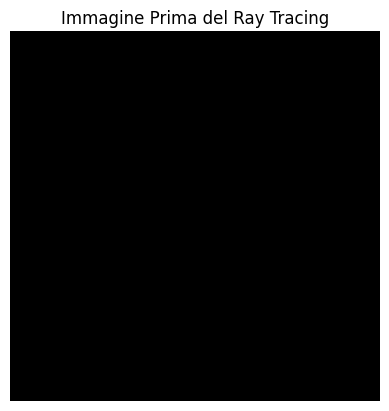

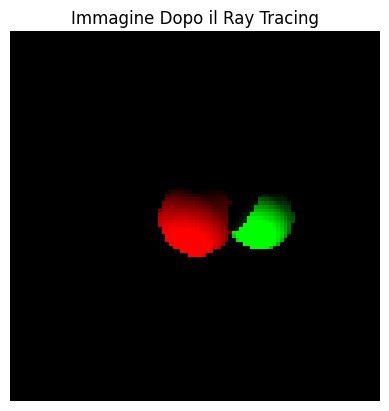

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Classe per definire una sfera
class Sphere:
    def __init__(self, center, radius, color, specular=0, reflective=False):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersect(self, ray_origin, ray_direction):
        # Risolve |O + tD - C|^2 = R^2 (equazione sfera)
        oc = ray_origin - self.center
        a = np.dot(ray_direction, ray_direction)
        b = 2 * np.dot(oc, ray_direction)
        c = np.dot(oc, oc) - self.radius**2
        discriminant = b**2 - 4*a*c
        if discriminant < 0:
            return None  # Nessuna intersezione
        t1 = (-b - np.sqrt(discriminant)) / (2*a)
        t2 = (-b + np.sqrt(discriminant)) / (2*a)
        if t1 > 0:
            return t1
        if t2 > 0:
            return t2
        return None  # Nessuna intersezione valida

# Funzione per visualizzare il frame buffer
def display_framebuffer(framebuffer, title):
    plt.imshow(framebuffer)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Funzione per calcolare l'illuminazione di un punto
def compute_lighting(point, normal, view, lights, scene_objects):
    intensity = 0
    for light in lights:
        light_dir = light["position"] - point
        light_dir = light_dir / np.linalg.norm(light_dir)
        
        # Ombra
        shadow_ray_origin = point + normal * 1e-4
        shadow_ray_direction = light_dir
        shadow_intersection = any(
            obj.intersect(shadow_ray_origin, shadow_ray_direction) 
            for obj in scene_objects
        )
        if shadow_intersection:
            continue

        # Diffusa
        intensity += max(0, np.dot(normal, light_dir)) * light["intensity"]
    return intensity

# Funzione principale di ray tracing
def ray_tracing(framebuffer, camera_position, scene_objects, lights):
    h, w, _ = framebuffer.shape
    for y in range(h):
        for x in range(w):
            # Calcolo della direzione del raggio
            px = (x / w) * 2 - 1  # Coordinate normalizzate
            py = (y / h) * 2 - 1
            ray_direction = np.array([px, py, -1]) - camera_position
            ray_direction = ray_direction / np.linalg.norm(ray_direction)
            
            # Calcolo colore per il raggio
            color = np.array([0, 0, 0])  # Colore di default (sfondo)
            for obj in scene_objects:
                t = obj.intersect(camera_position, ray_direction)
                if t:
                    intersection = camera_position + t * ray_direction
                    normal = (intersection - obj.center) / np.linalg.norm(intersection - obj.center)
                    lighting = compute_lighting(intersection, normal, -ray_direction, lights, scene_objects)
                    color = obj.color * lighting
            framebuffer[y, x] = np.clip(color, 0, 1)

# Configurazione scena
scene_objects = [
    Sphere(center=[0, 0, -5], radius=1, color=[1, 0, 0]),
    Sphere(center=[2, 0, -6], radius=1, color=[0, 1, 0])
]
lights = [
    {"position": np.array([-5, 5, 0]), "intensity": 1.0},
    {"position": np.array([5, 5, 0]), "intensity": 0.5}
]
camera_position = np.array([0, 0, 0])
image_size = (100, 100, 3)  # Frame buffer con pixel RGB
framebuffer = np.zeros(image_size)  # Frame buffer inizializzato al nero

# Visualizza immagine prima del ray tracing
display_framebuffer(framebuffer, "Immagine Prima del Ray Tracing")

# Esegui ray tracing
ray_tracing(framebuffer, camera_position, scene_objects, lights)

# Visualizza immagine dopo il ray tracing
display_framebuffer(framebuffer, "Immagine Dopo il Ray Tracing")
